Кирилл Лалаянц, R33352

# Лабораторная работа No9
# В -- 11
## Регуляторов с заданной степенью устойчивости

Импорт необходимых для работы библиотек. 

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l
# plt.rcParams['text.usetex'] = True

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
np.set_printoptions(precision=2)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [31]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


## Task1

In [32]:
task1_A = np.array([
    [-4, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 5],
    [0, 0, -5, 1]
])

task1_B = np.array([[0], 
                    [2], 
                    [0], 
                    [9]])

task1_alphas = np.array([0.1, 1, 2, 3, 4, 5, 10, 20, 50, 100, 1000, 10000])

task1_x0 = np.array([1, 1, 1, 1])

In [33]:
check_controllability_eigens(task1_A, task1_B)

Eigen values of A:
   [1.+5.j]: controllable
   [1.-5.j]: controllable
   [-4.+0.j]: not controllable
   [1.+0.j]: controllable


In [34]:
def task1_simulate(A, B, K, x0, ts):
    print(f'spec(A + B@K): {np.linalg.eigvals(A + B@K)}; stable: {np.all(np.linalg.eigvals(A + B@K).real < 0)}')
    ss = control.ss(A + B@K, A*0, A*0, A*0)
    return control.forced_response(ss, X0=x0, T=ts)

def task1_get_K(A, B, alpha):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
        # print(P.value)
    except Exception:
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

In [35]:
# fig, axs = plt.subplots(2, 2, figsize=(8, 8))
# plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
task1_reses = dict()
ts = get_t(10)
for alpha in task1_alphas:
    print(f'========   {alpha = }   =========')
    K, status = task1_get_K(task1_A, task1_B, alpha)
    if not status:
        print(':(')
        continue
    print(f'{K = }')
    task1_reses[alpha] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 0.1   =========
Optimization error: 0.0
spec(P): [ 4.11 33.2  14.27  2.91]; P >> 0: True
spec(lmi): [-32.05 -14.24 -11.07  -3.05]; lyapunov_lmi <<= 0: True
K = array([[-5.34e-16, -9.12e-01, -2.89e-01, -3.22e-01]])
spec(A + B@K): [-0.68+5.53j -0.68-5.53j -0.36+0.j   -4.  +0.j  ]; stable: True
========   alpha = 1.0   =========
Optimization error: 0.0
spec(P): [12.62 98.08 33.43  2.28]; P >> 0: True
spec(lmi): [-75.74  -4.36 -37.73 -27.74]; lyapunov_lmi <<= 0: True
K = array([[ 3.26e-16, -2.58e+00, -9.45e-01, -3.23e-01]])
spec(A + B@K): [-1.84+6.77j -1.84-6.77j -1.39+0.j   -4.  +0.j  ]; stable: True
========   alpha = 2.0   =========
Optimization error: 0.0
spec(P): [ 53.82 334.89  87.03   2.26]; P >> 0: True
spec(lmi): [-215.29   -8.29 -119.91  -82.84]; lyapunov_lmi <<= 0: True
K = array([[-8.56e-16, -6.76e+00, -2.21e+00,  1.45e-01]])
spec(A + B@K): [-3.3 +8.66j -3.3 -8.66j -2.62+0.j   -4.  +0.j  ]; stable: True
========   alpha = 3.0   =========
Optimization error: 0

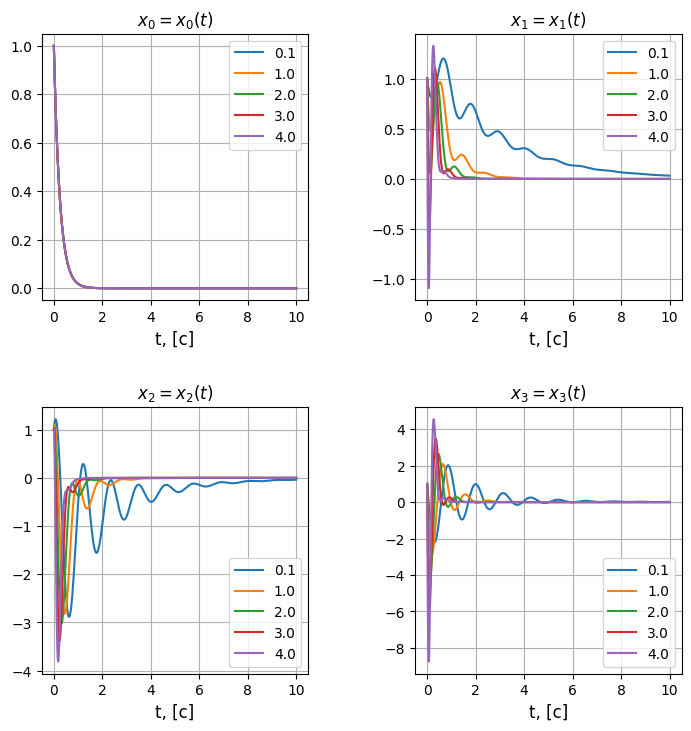

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, alpha in enumerate(task1_reses):
    res, _ = task1_reses[alpha]
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'{alpha}') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task1_states.jpg')

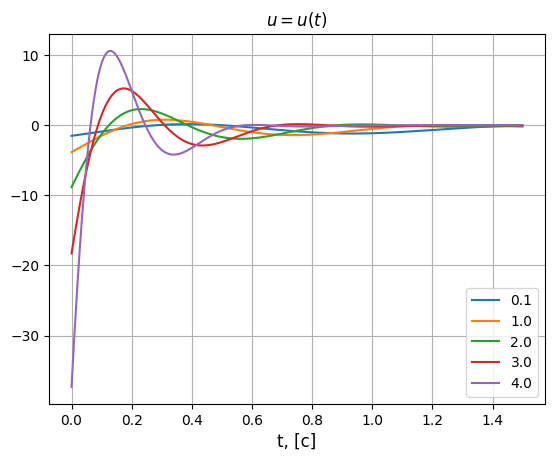

In [37]:
for indx, alpha in enumerate(task1_reses):
    res, K = task1_reses[alpha]
    us = K @ res.states
    plt.plot(ts[:len(ts)//100 * 15], us[0, :len(ts)//100 * 15], label=f'{alpha}') 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u = u(t)$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task1_us.jpg')

## Task 2

In [43]:
def task2_get_K_with_constraint(A, B, x, alpha, mu):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y

    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, (mu**2) * np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(0)
    prob = cvxpy.Problem(objective, constraints)
    
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
    except Exception:
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

def task2_get_K_min(A, B, x, alpha):
    mumu = cvxpy.Variable((1, 1))
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    new_const1 = cvxpy.bmat([[P, x], [x.T, np.ones((1, 1))]])
    new_const2 = cvxpy.bmat([[P, Y.T], [Y, mumu @ np.identity(B.shape[1])]])
    
    constraints = [P >> np.eye(4), lyapunov_lmi << 0, new_const1 >> 0, new_const2 >> 0]
    objective = cvxpy.Minimize(mumu)
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve(solver="CVXOPT")}')
    except Exception:
        return (0, 0, False)
    return np.sqrt(mumu.value)[0][0], Y.value @ np.linalg.pinv(P.value), True


In [49]:
task2_reses1 = dict()
task2_alpha = 1
min_mu, min_K, valid = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha)
ts = get_t(5)
for mu in np.linspace(min_mu, 10 * min_mu, 5):
    print(f'========   {mu = }   =========')
    K, status = task2_get_K_with_constraint(task1_A, task1_B, task1_x0.reshape(4, 1), task2_alpha, mu)
    if not status:
        print(':(')
        continue
    task2_reses1[mu] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

Optimization error: 9.500734593363262
========   mu = 3.0823261659602577   =========
Optimization error: 0.0
spec(P): [4.33e+05 4.73e+01 1.55e+00 1.93e+01]; P >> 0: True
spec(lmi): [-2.60e+06 -6.99e-06 -3.41e-06 -2.07e-07]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.+5.5j -1.-5.5j -1.+0.j  -4.+0.j ]; stable: True
========   mu = 10.017560039370837   =========
Optimization error: 0.0
spec(P): [ 8.14  1.86 25.46 63.16]; P >> 0: True
spec(lmi): [-47.97 -12.71  -0.74  -6.04]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.31+6.79j -1.31-6.79j -1.18+0.j   -4.  +0.j  ]; stable: True
========   mu = 16.952793912781416   =========
Optimization error: 0.0
spec(P): [ 8.03  1.72 23.68 58.04]; P >> 0: True
spec(lmi): [-47.73  -0.62  -5.95 -12.01]; lyapunov_lmi <<= 0: True
spec(A + B@K): [-1.34+7.03j -1.34-7.03j -1.17+0.j   -4.  +0.j  ]; stable: True
========   mu = 23.888027786191994   =========
Optimization error: 0.0
spec(P): [ 1.79  8.36 24.12 60.34]; P >> 0: True
spec(lmi): [-49.58  -0.71  -6.72

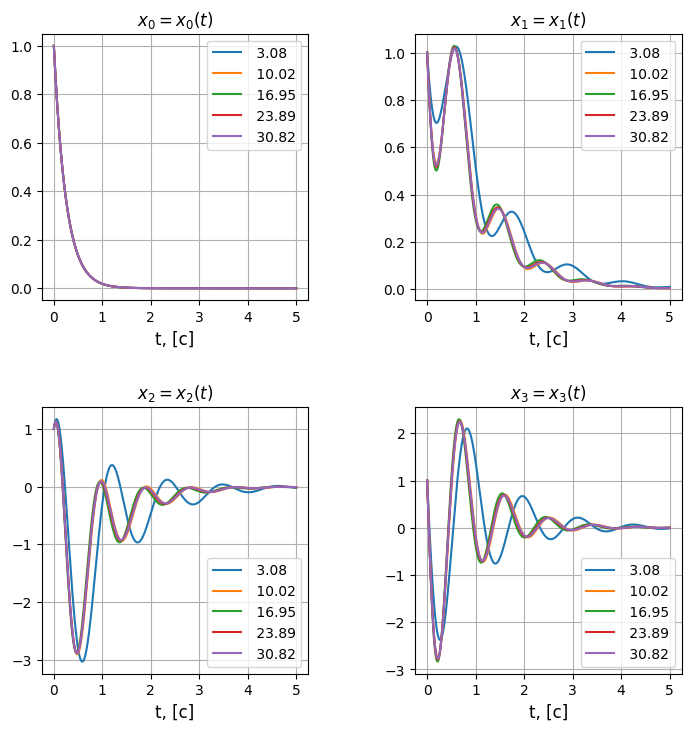

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for indx, mu in enumerate(task2_reses1):
    res, _ = task2_reses1[mu]
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'{mu : .2f}') 
for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task2_1_states.jpg')

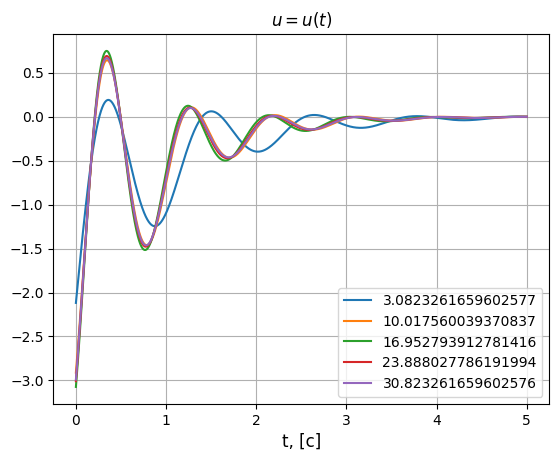

In [51]:
for indx, mu in enumerate(task2_reses1):
    res, K = task2_reses1[mu]
    us = K @ res.states
    plt.plot(ts, us[0], label=f'{mu}') 
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u = u(t)$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task2_1_us.jpg')

In [52]:
for alpha in task1_reses:
    print(f'========   {alpha = }   =========')
    min_mu, K, val = task2_get_K_min(task1_A, task1_B, task1_x0.reshape(4, 1), alpha - 0.1)
    if not val:
        print(':(')
        continue
    task2_reses1[(alpha, min_mu)] = (task1_simulate(task1_A, task1_B, K, task1_x0, ts), K)

========   alpha = 0.1   =========
Optimization error: 1.211148360074325
spec(A + B@K): [-2.59e-07+5.12j -2.59e-07-5.12j -2.75e-07+0.j   -4.00e+00+0.j  ]; stable: True
========   alpha = 1.0   =========
Optimization error: 8.009481565489995
spec(A + B@K): [-0.9+5.45j -0.9-5.45j -0.9+0.j   -4. +0.j  ]; stable: True
========   alpha = 2.0   =========
Optimization error: 36.55993461474184
spec(A + B@K): [-1.9+6.06j -1.9-6.06j -1.9+0.j   -4. +0.j  ]; stable: True
========   alpha = 3.0   =========
Optimization error: 124.36776806403921
spec(A + B@K): [-2.9+6.85j -2.9-6.85j -2.9+0.j   -4. +0.j  ]; stable: True
========   alpha = 4.0   =========
:(
